In [1]:
### paquetes de impotacion y manejo de datos
import pandas as pd
import numpy as np

# ### paquetes de graficos
import matplotlib.pyplot as plot
# from scipy import stats

# ######  paquetes de analitica de datos
# from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

archivo='AirQualityUCI.csv'

ds=pd.read_csv(archivo, sep=';', decimal=',')


# # plot.hist(x=pepito['horsepower'])
# # plot.subplots()
# # plot.hist(x=pepito['acceleration'])
# # plot.boxplot(x=pepito['Viscera weight'])
# # plot.subplots()
# plot.bar(ds['cylinders'],ds['displacement'])
# # #plot.hist(x=pepito['Sex'])
# X=ds['cylinders']  
# Y=ds['displacement']

# X_train, X_test, y_train, y_test = train_test_split(
#                                         X,
#                                         Y,
#                                         train_size   = 0.6,
#                                     )


Se elimina la ultima columna porque esta no nos sirve para el analisis, esto debido a que tiene todos sus valores como nan

In [2]:
#Delete the last column

ds=ds.drop(ds.columns[15],axis=1)

#Renombrar columnas y eliminar filas con valores faltantes y negativos

Ahora se renombraron las columnas del conjunto de datos para que tengan nombres más detallados y fáciles de trabajar:

In [3]:
#Column names

Nombre_columnas=['Date', 
'Time',
'CO',
'PT08.S1 CO',
'Non Metanic HydroCarbons Concentration',
'Benzene Concentration', 
'PT08.S2 NMHC', 
'NOx Concentration',
'PT08.S3 NOx',
'NO2 Concentration',
'PT08.S4 NO2',
'PT08.S5 O3',
'Temperature',
'Relative Humidity',
'Absolute Humidity',]

ds.columns=Nombre_columnas

Ahora se borran las columnas Date y Time, ya que no se van a utilizar en el analisis y para facilitar los analisis posteriores

In [13]:
#Delete rows with NaN values
ds = ds.drop(['Date', 'Time'], axis=1)

Se borran todos los datos -200 y nan de todas las columnas porque son datos que no nos sirven para el analisis y ademas que son datos que no se pueden solucionar, y los que se pueden solucionar no sirven mucho

In [14]:
ds = ds.replace(-200, np.nan)
ds = ds.dropna()

A continuación, se identificaron los datos atípicos en las columnas "PT08.S2 NMHC", "PT08.S1 CO" y "PT08.S5 O3", y se creó una variable para ubicarlos

Tambien se eliminaron los valores atípicos cercanos a cero y se interpoló para los valores restantes. Para ello, se creó una función que realiza la interpolación

Y se aplicó esta función para cada columna de valores atípicos para poder eliminarlos



In [15]:
# Variable para ubicar los datos atípicos
outliers = ds[['PT08.S2 NMHC', 'PT08.S1 CO', 'PT08.S5 O3']].copy()

# Función para eliminar los outliers con interpolación
def interpolate_outliers(column):
    column.interpolate(inplace=True)

for col in outliers.columns:
    # Eliminar los outliers con valores cercanos a cero
    outliers = outliers.drop(outliers.index[outliers[col] < 1])
    # Identificar los outliers restantes
    q1 = outliers[col].quantile(0.25)
    q3 = outliers[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    # Interpolar los valores outliers
    outliers.loc[(outliers[col] < lower_bound) | 
                 (outliers[col] > upper_bound), col] = np.nan
    interpolate_outliers(outliers[col])

# Eliminar las filas con NaN después de la interpolación
ds = ds.dropna()


Ahora se debe estimar el modelo de regresión lineal con múltiples entradas para predecir las salidas PT08.S2 NMHC, PT08.S1 CO y PT08.S5 O3 utilizando los datos de la base de datos. Para hacer esto primero se seleccionan las columnas importantes de los datos y se separan en conjuntos de entrenamiento y prueba donde se usa el 70% para el entrenamiento.

Tambien se entrenan tres modelos de regresión lineal, uno para cada salida que se quiere predecir utilizando los datos del entrenamiento. Luego se utilizan estos modelos para realizar predicciones en los datos de prueba.

Y ya por ultimo se calculan los valores de R2 para cada modelo y se imprimen en pantalla.

In [17]:

# Separar los datos en conjuntos de entrenamiento y prueba
X = ds[['CO', 'Non Metanic HydroCarbons Concentration', 'Benzene Concentration', 
        'NOx Concentration', 'NO2 Concentration', 'Temperature', 
        'Relative Humidity', 'Absolute Humidity']]
y = ds[['PT08.S2 NMHC', 'PT08.S1 CO', 'PT08.S5 O3']]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

# Entrenar los modelos de regresión lineal
reg1 = LinearRegression().fit(X_train, y_train['PT08.S2 NMHC'])
reg2 = LinearRegression().fit(X_train, y_train['PT08.S1 CO'])
reg3 = LinearRegression().fit(X_train, y_train['PT08.S5 O3'])

# Realizar predicciones en los datos de prueba
# Realizar predicciones en los datos de prueba
y_pred1 = reg1.predict(X_test)
y_pred2 = reg2.predict(X_test)
y_pred3 = reg3.predict(X_test)

# Calcular R2 y error cuadrático medio
r2_1 = r2_score(y_test['PT08.S2 NMHC'], y_pred1)
r2_2 = r2_score(y_test['PT08.S1 CO'], y_pred2)
r2_3 = r2_score(y_test['PT08.S5 O3'], y_pred3)

print('El valor valor de r2 de PT08.S2 NMHC es: ', r2_1)
print('El valor valor de r2 de PT08.S1 CO es: ', r2_2)
print('El valor valor de r2 de PT08.S5 O3 es: ', r2_3)

El valor valor de r2 de PT08.S2 NMHC es:  0.9839932728323803
El valor valor de r2 de PT08.S1 CO es:  0.9276852494205146
El valor valor de r2 de PT08.S5 O3 es:  0.8991793527631035


Los tres modelos de regresión lineal dan resultado en valores altos de R2, lo que sugiere que son modelos precisos en la predicción de los valores de las tres variables de salida (PT08.S2 NMHC, PT08.S1 CO, PT08.S5 O3) teniendo en cuanta las ocho variables de entrada suministradas.

De los tres modelos, el que predice la concentración de PT08.S2 NMHC presenta el valor más alto de R2 (0.984), lo que indica que es el modelo mejor ajustado y puede explicar el 98.4% de la variabilidad en la concentración de NMHC. Por otro lado, el modelo que predice la concentración de PT08.S1 CO tiene un valor de R2 de 0.928, lo que indica que puede explicar el 92.8% de la variabilidad en la concentración de CO. Finalmente, el modelo que predice la concentración de PT08.S5 O3 tiene un valor de R2 de 0.899, lo que indica que puede explicar el 89.9% de la variabilidad en la concentración de O3.

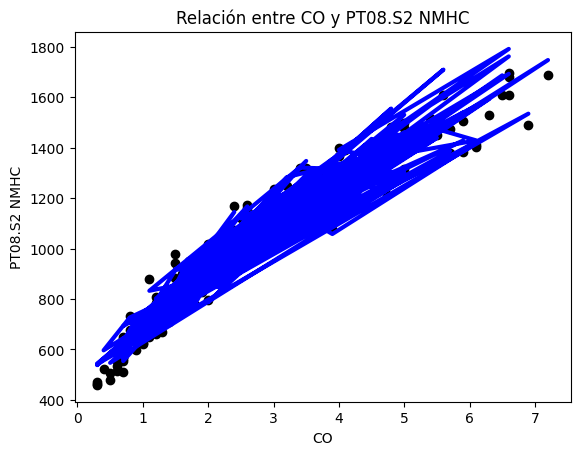

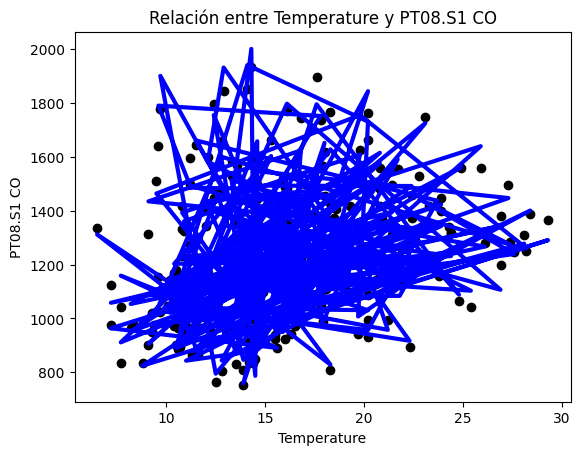

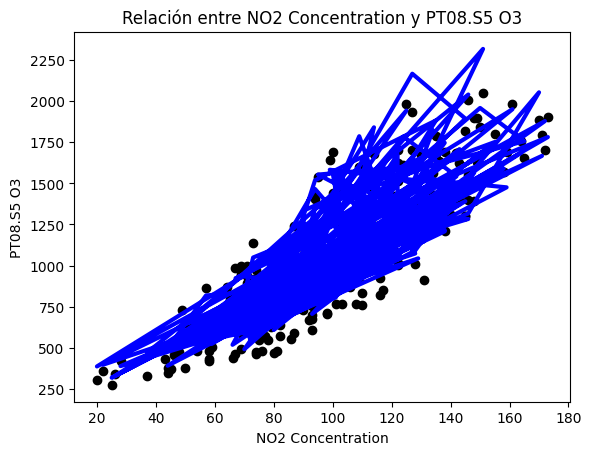

In [23]:
# Gráfica de dispersión para PT08.S2 NMHC
plot.scatter(X_test['CO'], y_test['PT08.S2 NMHC'], color='black')
plot.plot(X_test['CO'], y_pred1, color='blue', linewidth=3)

plot.xlabel('CO')
plot.ylabel('PT08.S2 NMHC')
plot.title('Relación entre CO y PT08.S2 NMHC')

plot.show()

# Gráfica de dispersión para PT08.S1 CO
plot.scatter(X_test['Temperature'], y_test['PT08.S1 CO'], color='black')
plot.plot(X_test['Temperature'], y_pred2, color='blue', linewidth=3)

plot.xlabel('Temperature')
plot.ylabel('PT08.S1 CO')
plot.title('Relación entre Temperature y PT08.S1 CO')

plot.show()

# Gráfica de dispersión para PT08.S5 O3
plot.scatter(X_test['NO2 Concentration'], y_test['PT08.S5 O3'], color='black')
plot.plot(X_test['NO2 Concentration'], y_pred3, color='blue', linewidth=3)

plot.xlabel('NO2 Concentration')
plot.ylabel('PT08.S5 O3')
plot.title('Relación entre NO2 Concentration y PT08.S5 O3')

plot.show()

En la primera gráfica los puntos parecen estar muy pegados, lo cual indica que hay una alta correlacion entre la variiable de entrada y la variable de salida. En la segunda grafica, los puntos están bastante separados, lo cual muestra que la variable de entrada no tiene una fuerte correlación con la variable de salida. Y por ultimo, en la tercera gráfica, los puntos también parecen estar bastante pegados, lo que indica una correlación moderada entre la variable de entrada y la variable de salida.